In [19]:
""" 
dependencies:
  - python=3.8.17
  - numpy=1.24.0
  - matplotlib=3.7.1
  - pandas=2.0.2 
"""
import os
import random
import datetime
from itertools import product 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

# import random
# random.seed(42)
# np.random.seed(42)
# np.random.RandomState(42)
# os.environ['TF_DETERMINISTIC_OPS'] = '1' 

finish_sound = "afplay /Users/mehmet/Documents/vs-code/winsquare.mp3"
# play sound when finished
# os.system(finish_sound)

In [20]:
# Read data from npy file ( already preprocessed )
filename = 'original-numpy'
# filename = 'pca-numpy'
X_train = np.load(f'dataset/{filename}/X_train.npy')
X_val = np.load(f'dataset/{filename}/X_val.npy')
X_test = np.load(f'dataset/{filename}/X_test.npy')
y_train = np.load(f'dataset/{filename}/y_train.npy')
y_val = np.load(f'dataset/{filename}/y_val.npy')
y_test = np.load(f'dataset/{filename}/y_test.npy')

# # Push all X to positive side
# X_train = X_train + np.abs(np.min(X_train))
# X_val = X_val + np.abs(np.min(X_val))
# X_test = X_test + np.abs(np.min(X_test))

# # Remove one hot encoding from y
# y_train = np.argmax(y_train, axis=1)
# y_val = np.argmax(y_val, axis=1)
# y_test = np.argmax(y_test, axis=1)

# X_train = X_train - np.min(X_train, axis=0) + 1e-3
# #X_train = X_train / np.max(X_train, axis=0)
# X_val = X_val - np.min(X_val, axis=0) + 1e-3
# #X_val = X_val / np.max(X_val, axis=0)
# X_test = X_test - np.min(X_test, axis=0) + 1e-3
# #X_test = X_test / np.max(X_test, axis=0)

print(X_train.shape, y_train.shape,'\n', X_val.shape, y_val.shape,'\n', X_test.shape, y_test.shape)

(5120, 10859) (5120, 4) 
 (640, 10859) (640, 4) 
 (640, 10859) (640, 4)


In [21]:
class NN:
    def __init__(self, seed=42):
        np.random.seed(seed)
        self.n_features = None
        self.n_classes = None
        
        self.input_layer = None
        self.layers = []
        self.output_layer = None
        self.Weights = []
        self.Biases = []
        
        self.now = None
        self.print_result = True
        self.history_steps1 = None
        self.history = None
        self.validation_accuracy = None
        
    def validation_accuracy(self):
        return self.validation_accuracy
    
    def history(self):
        return self.history
    
    def load_history(self):
        pd_hist = pd.read_csv(f'model-comparison/{self.now}/history.csv')
        self.history = np.array(pd_hist.iloc[:,1:])
        
    def plot(self, save = True):
        # Save history as csv file
        history_local = self.history
        if type(history_local) is not pd.DataFrame:
            history_df = pd.DataFrame(history_local)
        if save == True:
            hist_csv_file = f'model-comparison/{self.now}/history.csv'
            with open(hist_csv_file, mode='w') as f:
                history_df.to_csv(f) 
        # Plot Loss and Accuracy History as Subplots
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(10, 2)
        index = np.arange(1,self.history.shape[1]+1)*self.history_steps1

        ax[0].plot(index, self.history[0], label='Training Loss')
        ax[0].plot(index, self.history[2], label='Validation Loss')
        ax[0].set_title('Loss History')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        ax[1].plot(index, self.history[1], label='Training Accuracy')
        ax[1].plot(index, self.history[3], label='Validation Accuracy')
        ax[1].set_title('Accuracy History')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        if save is True and self.now is not None:
            plt.savefig(f'model-comparison/{self.now}/plot.png')
        if self.print_result == True:
            plt.show()
        else:
            plt.close(fig)
        
    def add_input_layer(self):
        self.input_layer = True
    
    def add_hidden_layer(self, n_neurons, activation=None):
        self.layers.append((n_neurons, activation))
        
    def add_output_layer(self, activation='softmax'):
        self.layers.append((activation))

    def Initialize_weights(self, weight_init='zero'):
        for i in range(len(self.layers)):
            
            # All middle hidden layers
            if i != 0 and i != len(self.layers)-1:
                prev_n_neurons = self.layers[i-1][0]
                n_neurons = self.layers[i][0]
            # First Hidden layer
            elif i == 0:
                prev_n_neurons = self.n_features
                n_neurons = self.layers[i][0]
            # Output layer
            elif i == len(self.layers)-1:
                prev_n_neurons = self.layers[i-1][0]
                n_neurons = self.n_classes

            # Initialize weights and biases for each layer
            if weight_init == 'random':
                self.Weights.append(np.random.randn(prev_n_neurons, n_neurons)*0.01)
                self.Biases.append(np.random.randn(n_neurons)*0.01)
            elif weight_init == 'zero':
                self.Weights.append(np.zeros((prev_n_neurons, n_neurons)))
                self.Biases.append(np.zeros(n_neurons))
            elif weight_init == 'he-normal':
                # He Normal Initialization
                self.Weights.append(np.random.randn(prev_n_neurons, n_neurons)*np.sqrt(2/prev_n_neurons))
                self.Biases.append(np.random.randn(n_neurons)*np.sqrt(2/prev_n_neurons))
            elif weight_init == 'xavier-normal':
                # Xavier Normal Initialization
                self.Weights.append(np.random.randn(prev_n_neurons, n_neurons)*np.sqrt(1/prev_n_neurons))
                self.Biases.append(np.random.randn(n_neurons)*np.sqrt(1/prev_n_neurons))
            #print("Weights shape:", self.Weights[i].shape)
            #print ("Biases shape:", self.Biases[i].shape)

    def Activation(self, output, activation=None, derivative=False):
        if activation == 'relu':
            if derivative:
                return np.where(output > 0, 1, 0)
            else:
                return np.maximum(0, output)
        elif activation == 'leaky-relu':
            if derivative:
                return np.where(output > 0, 1, 0.01)
            else:
                return np.where(output > 0, output, 0.01 * output)
            
        elif activation == 'sigmoid':
            if derivative:
                sigmoid_output = self.Activation(output, activation='sigmoid')
                return sigmoid_output * (1 - sigmoid_output)
            else:
                return 1 / (1 + np.exp(-output))
        elif activation == 'softmax':
            if derivative:
                # The derivative of softmax is a bit involved and requires the Jacobian matrix
                # For simplicity, we can assume softmax is only used in the output layer
                # and compute its derivative accordingly
                softmax_output = self.Activation(output, activation='softmax')
                return softmax_output * (1 - softmax_output)
            else:
                exp_output = np.exp(output)
                return exp_output / np.sum(exp_output, axis=1, keepdims=True)


        
    def Forward(self, X):
        # Forward pass for each layer
        input = X
        outputs = []
        for layer_num in range(len(self.layers)):
                layer = self.layers[layer_num]
                if layer_num == len(self.layers) - 1:
                    activation = layer
                else:
                    activation = layer[1]
                W = self.Weights[layer_num]
                b = self.Biases[layer_num]
                output = self.Activation(np.dot(input, W) + b, activation)
                outputs.append(output)
                # Next layer's input is this layer's output
                input = output
        return outputs

    def Backward(self, X, y, outputs):
        m = X.shape[0]  # Number of training examples
        # Initialize gradients
        dW = [0] * len(self.Weights)
        db = [0] * len(self.Biases)
        
        # Backward pass for all layers
        for layer_num in reversed(range(len(self.layers))):
            if layer_num == 0:
                # First hidden layer
                input_layer_backward = X
            else:
                input_layer_backward = outputs[layer_num-1]
            output_layer_backward = outputs[layer_num]
            layer = self.layers[layer_num]
            if layer_num == len(self.layers) - 1:
                activation = layer[0]
                # Last layer Compute gradients
                dZ = output_layer_backward - y
                dW[layer_num] = np.dot(input_layer_backward.T, dZ) / m
                db[layer_num] = np.sum(dZ, axis=0) / m
            else:
                activation = layer[1]      
                # Hidden layers Compute gradients
                dZ = np.dot(dZ, self.Weights[layer_num+1].T) * self.Activation(output_layer_backward, activation, derivative=True)
                dW[layer_num] = np.dot(input_layer_backward.T, dZ) / m
                db[layer_num] = np.sum(dZ, axis=0) / m
            #print(f'Layer {layer_num} dW shape: {dW[layer_num].shape} db shape: {db[layer_num].shape}')
                
        return dW, db


    def fit(self, X_nonbiased, y, X_val, y_val, now=None, max_epoch = 100, print_result=True, save=False,
            batch_size=5120, weight_init='zero', lr=0.01, lr_type = 'static', regularization='l2: 0.01',
            history_steps = 10, print_step = 50):
        
        start_time = datetime.datetime.now()
        # if there isn't model-comparison folder, create it
        if not os.path.exists('model-comparison'):
            os.mkdir('model-comparison')
        self.print_result = print_result
        if now is not None:
            self.now = now
        # Create folder for current model
            if not os.path.exists('model-comparison/'+now):
                os.mkdir('model-comparison/'+now)

        self.history_steps1 = history_steps
        self.history = np.zeros((4,max_epoch//history_steps))
        
        if regularization[0:2] == 'l2':
            # L2 regularization
            lmbda = float(regularization[4:])
        else:
            lmbda = 0
            
        lr_print = str(lr) + ' ' + lr_type
        model_specs = 'NN | Hidden Layers: {} |Batch Size: {} | Weight Init. {} | lr: {} | Lambda: {} | Max Epoch: {} |'.format(str(self.layers), batch_size, weight_init, lr_print, lmbda, max_epoch)
        
        self.n_features = X_nonbiased.shape[1]
        # y is one hot encoded
        self.n_classes = y.shape[1]
        
        self.Initialize_weights(weight_init=weight_init)
        
        old_val_acc = 0
        for epoch in range(1,max_epoch+1):
            # For all layers, Forward pass one time
            outputs = self.Forward(X_nonbiased)
            # For all layers, Backward pass one time
            dW, db = self.Backward(X_nonbiased, y, outputs)
            
            # Update weights and biases
            for layer_num in range(len(self.layers)):
                self.Weights[layer_num] -= lr * dW[layer_num] + 2 * lmbda * self.Weights[layer_num]
                self.Biases[layer_num] -= lr * db[layer_num]

            
            if epoch % history_steps == 0:
                # how to calculate accuracy
                loss = 0 # self.loss(X, y, self.W)
                val_loss = 0 # self.loss(X_val, y_val, self.W)
                # Compute accuracy
                pred = outputs[-1]
                accuracy = np.mean(np.argmax(pred, axis=1) == np.argmax(y, axis=1))
                # Validation accuracy
                pred_val = self.predict(X_val)
                val_acc = np.mean(pred_val == np.argmax(y_val, axis=1))
                self.validation_accuracy = val_acc
                self.history[:,(epoch//history_steps)-1] = np.array([loss, accuracy, val_loss, val_acc])
            
                if epoch % print_step == 0:
                    line1 = 'Epoch: ' + str(epoch)
                    #line2 = ' | Loss: ' + str(loss)[:5] + ' | Accuracy: ' + str(accuracy)[0:5]
                    #line3 = ' | Val. Loss: ' + str(val_loss)[:5] + ' | Val. Acc: ' + str(val_acc)[0:5]
                    line2 = ' | Accuracy: ' + str(accuracy)[0:5]
                    line3 = ' | Val. Acc: ' + str(val_acc)[0:5]
                    if print_result == True:
                        print(line1 + line2 + line3)
                    if now is not None:
                        with open('model-comparison/{}/log.txt'.format(now), 'a') as f:
                            f.write(line1 + line2 + line3 + '\n')
                    
                    if abs(old_val_acc-val_acc) < 0.005:
                        #lr = lr * 0.9
                        #print(f'Learning rate is updated to {lr}')
                        pass
                    
                    old_val_acc = val_acc
                    
            if epoch == max_epoch:
                end_time = datetime.datetime.now()
                if print_result == True:
                    print('Training finished. Time elapsed:', end_time - start_time, '\n')
                    print('Accuracy: ', str(accuracy)[0:5], 'Val. Accuracy: ', str(val_acc)[0:5])
                val_acc_print = str(val_acc*100)+ '00'
                if now is not None:
                    with open('model-comparison/{}/log.txt'.format(now), 'a') as f:
                        write_line = 'Training finished. Time elapsed: ' + str(end_time - start_time) + '\n'
                        f.write(write_line)
                    with open('model-comparison/{}/{}-val-acc.txt'.format(now,val_acc_print[0:5]), 'w') as f:
                        f.write(model_specs)
                    with open('model-comparison/last.txt', 'w') as f:
                        f.write(str(now))
    
    def predict(self, X):
        pred_l = self.Forward(X)
        pred = pred_l[-1]
        return np.argmax(pred, axis=1)

    def save_weights(self):
        # if there isn't model folder, create it
        if not os.path.exists('model-comparison/{}/model'.format(self.now)):
            os.mkdir('model-comparison/{}/model'.format(self.now))
        # save history steps
        with open('model-comparison/{}/model/history_steps.txt'.format(self.now), 'w') as f:
            f.write(str(self.history_steps1))
        # save layers first to txt file
        with open('model-comparison/{}/model/layers.txt'.format(self.now), 'w') as f:
            f.write(str(self.layers))        
        for i in range(len(self.layers)):
            filename = 'model-comparison/{}/model/weights{}.npy'.format(self.now, i+1)
            np.save(filename, self.Weights[i])
            filename2 = 'model-comparison/{}/model/biases{}.npy'.format(self.now, i+1)
            np.save(filename2, self.Biases[i])
            
    def load_weights(self, now):
        # load history steps
        with open('model-comparison/{}/model/history_steps.txt'.format(now), 'r') as f:
            self.history_steps1 = int(f.read())
        # load layers from txt file
        with open('model-comparison/{}/model/layers.txt'.format(now), 'r') as f:
            self.layers = list(eval(f.read()))
        for i in range(len(self.layers)):
            filename = 'model-comparison/{}/model/weights{}.npy'.format(now, i+1)
            self.Weights.append(np.load(filename))
            filename2 = 'model-comparison/{}/model/biases{}.npy'.format(now, i+1)
            self.Biases.append(np.load(filename2))
        self.now = now


In [22]:
class EvaluateModel():
    # Class to evaluate model performance, similar to sklearn.metrics ClassificationReport and ConfusionMatrix
    def __init__(self, y_true, y_pred, str1, now, save=True, print_result=True):
        self.y_true = np.argmax(y_true, axis=1)
        self.y_pred = y_pred
        if save == True:
            os.mkdir('model-comparison/'+now+'/'+str1)
            np.savetxt('model-comparison/{}/{}/pred.csv'.format(now,str1), y_pred, delimiter=',', fmt='%d')
        
        result = self.classification_report()
        fpr0 = 100 - float(result['precision'][0][0:4])
        line1 = 'Accuracy is: ' + str(result['f1-score']['accuracy'])
        line2 = 'F1 Score is: ' + str(result['f1-score']['weighted avg'])
        line3 = 'Precision of Class 0 is: ' + '{0:.2f}'.format(100-fpr0)+ ' %'
        line4 = '\nClassification Report:'
        line5 = '\nConfusion Matrix:'
        cm = self.confusion_matrix()
        line6 = '\n'
        res_total = line1 + '\n' + line2 + '\n' + line3 + '\n' + line4 + '\n' + str(result) + '\n' + line5 + '\n' + str(cm) + '\n' + line6
        # write to file
        if save == True:
            with open('model-comparison/{}/{}/report.txt'.format(now,str1), 'w') as f:
                f.write(res_total)
        if print_result == True:
            print(res_total)

    def accuracy_score(self, y_t, y_p):
        correct = sum(y_t == y_p)
        return correct / len(y_t)

    def scores(self, y_t, y_p, class_label= 1):
        true = y_t == class_label
        pred = y_p == class_label
        tp = sum(true & pred)
        fp = sum(~true & pred) 
        fn = sum(true & ~pred)
        tn = sum(~true & ~pred) 
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * (precision * recall) / (precision + recall)
        return precision, recall, f1
    
    def confusion_matrix(self,labels=None):
        labels = labels if labels else sorted(set(self.y_true) | set(self.y_pred))        
        indexes = {v:i for i, v in enumerate(labels)}
        matrix = np.zeros((len(indexes),len(indexes))).astype(int)
        for t, p in zip(self.y_true, self.y_pred):
            matrix[indexes[t], indexes[p]] += 1
        # print('Confusion Matrix: ')
        # print(pd.DataFrame(matrix, index=labels, columns=labels))
        return pd.DataFrame(matrix, index=labels, columns=labels)

    def classification_report(self):
        output_dict = {}
        support_list = []
        precision_list = []
        recall_list = []
        f1_list = []
        for i in np.unique(self.y_true):
            support = sum(self.y_true == i)
            precision, recall, f1 = self.scores(self.y_true, self.y_pred, class_label=i)
            output_dict[i] = {'precision':precision, 'recall':recall, 'f1-score':f1, 'support':support}
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
            support_list.append(support)
        support = np.sum(support_list)
        output_dict['accuracy'] = {'precision':0, 'recall':0, 'f1-score':self.accuracy_score(self.y_true, self.y_pred), 'support':support}
        # macro avg
        macro_precision = np.mean(precision_list)
        macro_recall = np.mean(recall_list)
        macro_f1 = np.mean(f1_list)
        output_dict['macro avg'] = {'precision':macro_precision, 'recall':macro_recall, 'f1-score':macro_f1, 'support':support}
        # weighted avg
        weighted_precision = np.average(precision_list, weights=support_list)
        weighted_recall = np.average(recall_list, weights=support_list)
        weighted_f1 = np.average(f1_list, weights=support_list)
        output_dict['weighted avg'] = {'precision':weighted_precision, 'recall':weighted_recall, 'f1-score':weighted_f1, 'support':support}
        # convert to dataframe and format
        report_d = pd.DataFrame(output_dict).T
        annot = report_d.copy()
        annot.iloc[:, 0:3] = (annot.iloc[:, 0:3]*100).applymap('{:.2f}'.format) + ' %'
        annot['support'] = annot['support'].astype(int)
        annot.loc['accuracy','precision'] = ''
        annot.loc['accuracy','recall'] = ''
        return annot

In [23]:
def GridSearch(model_options, X_train, y_train, X_val, y_val, X_test, y_test, print_result=False, seed=42):
    # Grid Search Function
    best_metric = 0
    for i in range(len(model_options)):
        models = model_options[i]
        model_number = i + 1
        now = datetime.datetime.now().strftime("%d-%m-%H-%M")
        # Create folder for current model
        if not os.path.exists('model-comparison/'+now):
            os.mkdir('model-comparison/'+now)
        else:
            now = now + str('--1')
            os.mkdir('model-comparison/'+now)
        model = NN(seed=seed)
        start_time = datetime.datetime.now()
        model.add_input_layer() # 10859
        hidden_layers = len(models[-1])
        for i in range(hidden_layers):
            model.add_hidden_layer(models[-1][i][0], activation=models[-1][i][1])
        model.add_output_layer()
        model.fit(X_train, y_train, X_val, y_val, now, print_result=print_result, max_epoch=models[0], save=True,
                  weight_init= models[1], batch_size=models[2], lr=models[3], lr_type=models[4], regularization=models[5])
        end_time = datetime.datetime.now()
        time_elapsed = str(end_time - start_time)[2:7]
        metric = model.validation_accuracy
        model.save_weights()
        model.plot()
        y_pred = model.predict(X_val)
        results = EvaluateModel(y_val, y_pred, 'val', now, print_result=print_result)
        y_pred = model.predict(X_test)
        results = EvaluateModel(y_test, y_pred, 'test', now, print_result=print_result)
        if metric > best_metric:
            best_metric = metric
            best_model = now
        print('Model ', str(model_number), ' saved with name: ', now)
        print(models, 'Val-Accuracy:', metric)

        # append to txt file
        lr_print = str(models[3]) + ' ' + models[4]
        model_specs = 'NN | Batch Size: {} | Weight Init: {} | Lr: {} | Reg: {} | Max Epoch: {}'.format(models[2], models[1], lr_print, models[5], models[0])
        with open('model-comparison/best-models.txt', 'a') as f:
            f.write(now + ' | ' + model_specs + ' | ' + str(metric) + ' | Time Elapsed: '+ time_elapsed + ' | Hidden Layers: '+ str(models[-1]) +'\n')
        print(len(model_options)-model_number, 'models left to train.')
    best_metric = str(best_metric*100)[:5]
    print('Best Model is:', best_model, 'with validation accuracy:', best_metric, '%')

In [24]:
def TrainModel(hidden_layers, max_epoch, batch_size, weight_init, lr, lr_type, regularization):
    model_options = [[max_epoch, weight_init, batch_size, lr, lr_type, regularization, hidden_layers]]
    return model_options

Epoch: 50 | Accuracy: 0.833 | Val. Acc: 0.693
Epoch: 100 | Accuracy: 0.956 | Val. Acc: 0.785
Epoch: 150 | Accuracy: 0.988 | Val. Acc: 0.839
Epoch: 200 | Accuracy: 0.995 | Val. Acc: 0.867
Epoch: 250 | Accuracy: 0.998 | Val. Acc: 0.878
Epoch: 300 | Accuracy: 0.999 | Val. Acc: 0.893
Epoch: 350 | Accuracy: 0.999 | Val. Acc: 0.903
Epoch: 400 | Accuracy: 1.0 | Val. Acc: 0.915
Epoch: 450 | Accuracy: 1.0 | Val. Acc: 0.920
Epoch: 500 | Accuracy: 1.0 | Val. Acc: 0.925
Epoch: 550 | Accuracy: 1.0 | Val. Acc: 0.931
Epoch: 600 | Accuracy: 1.0 | Val. Acc: 0.934
Epoch: 650 | Accuracy: 1.0 | Val. Acc: 0.937
Epoch: 700 | Accuracy: 1.0 | Val. Acc: 0.939
Epoch: 750 | Accuracy: 1.0 | Val. Acc: 0.940
Epoch: 800 | Accuracy: 1.0 | Val. Acc: 0.943
Epoch: 850 | Accuracy: 1.0 | Val. Acc: 0.945
Epoch: 900 | Accuracy: 1.0 | Val. Acc: 0.95
Epoch: 950 | Accuracy: 1.0 | Val. Acc: 0.95
Epoch: 1000 | Accuracy: 1.0 | Val. Acc: 0.951
Training finished. Time elapsed: 0:05:37.542130 

Accuracy:  1.0 Val. Accuracy:  0.951


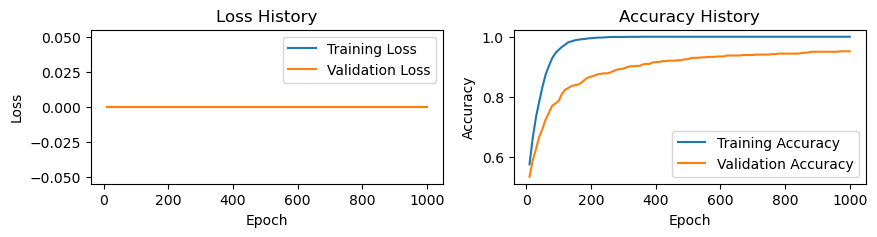

Accuracy is: 95.16 %
F1 Score is: 95.13 %
Precision of Class 0 is: 95.70 %

Classification Report:
             precision   recall f1-score  support
0              95.72 %  97.81 %  96.75 %      320
1              95.89 %  93.75 %  94.81 %      224
2              91.01 %  91.01 %  91.01 %       89
3             100.00 %  71.43 %  83.33 %        7
accuracy                         95.16 %      640
macro avg      95.66 %  88.50 %  91.48 %      640
weighted avg   95.17 %  95.16 %  95.13 %      640

Confusion Matrix:
     0    1   2  3
0  313    3   4  0
1   11  210   3  0
2    3    5  81  0
3    0    1   1  5


Accuracy is: 96.41 %
F1 Score is: 96.40 %
Precision of Class 0 is: 96.60 %

Classification Report:
             precision   recall f1-score  support
0              96.60 %  97.81 %  97.20 %      320
1              96.41 %  95.98 %  96.20 %      224
2              95.45 %  93.33 %  94.38 %       90
3             100.00 %  83.33 %  90.91 %        6
accuracy                         96.

0

In [27]:
# Train New Model
hidden_layers = [(64, 'leaky-relu'),
                 (32, 'leaky-relu')]

model_parameters = TrainModel(hidden_layers,
    max_epoch=1000, batch_size=5120, weight_init='he-normal', 
    lr=0.01, lr_type='static', regularization='l2: 0.0001')

GridSearch(model_parameters, X_train, y_train, X_val, y_val, X_test, y_test, print_result=True, seed=42)

os.system(finish_sound)

In [17]:
# Grid Search Combinations
hidden_layers = [[(64, 'leaky-relu'),
                 (32, 'leaky-relu')]]
max_epoch = [100]
weight_init = ['he-normal']
batch_size = [5120] # [1, 512, 5120]
lr = [0.01] # [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
lr_type = ['static']
regularization = ['l2: 0.001', 'l2: 0.0001','l2: 0.0001']
params = [max_epoch, weight_init, batch_size, lr, lr_type, regularization, hidden_layers]
model_options = list(product(*params))
print('Number of combinations:', len(model_options))
print('Combination 1:', model_options[0])

Number of combinations: 3
Combination 1: (100, 'he-normal', 5120, 0.01, 'static', 'l2: 0.001', [(64, 'leaky-relu'), (32, 'leaky-relu')])


In [ ]:
# Grid Search All Combinations

GridSearch(model_options, X_train, y_train, X_val, y_val, X_test, y_test, seed=42)
os.system(finish_sound)

In [ ]:
""" 
# Train Model
now = datetime.datetime.now().strftime("%d-%m-%H-%M")
model = NN()
model.add_input_layer() # 10859
model.add_hidden_layer(64, activation='leaky-relu')
model.add_hidden_layer(32, activation='leaky-relu')
model.add_output_layer()
model.fit(X_train, y_train, X_val, y_val, max_epoch=1000, now=now, print_result=True, save=True,
          batch_size=5120, weight_init='he-normal', lr=0.01, lr_type='static', regularization='l2: 0',
          history_steps=10, print_step=50)

model.save_weights()
model.plot()

y_pred = model.predict(X_val)
results = EvaluateModel(y_val, y_pred, 'val', now=now, save=True, print_result=True)

y_pred = model.predict(X_test)
results = EvaluateModel(y_test, y_pred, 'test', now=now, save=True, print_result=True) 
"""

In [ ]:
""" 
# Load Model
now = '20-12-05-29'

model = NN()
model.load_weights(now)
model.load_history()
model.plot(save=False)

y_pred = model.predict(X_val)
results = EvaluateModel(y_val, y_pred, 'val', now=now, save=False, print_result=True)

y_pred = model.predict(X_test)
results = EvaluateModel(y_test, y_pred, 'test', now=now, save=False, print_result=True)
""" 